In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Runner v2.0
> Exception Control Flow

We're now going to rework our Runner. 

In [2]:
#export

from exp.nb_05 import *

# import torch.nn.functional as F
# import torch.nn as nn
# import torch.optim as optim

## Get Data

In [3]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [4]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

## Callbacks

Previously, our `Callback` parent class was 

In [5]:
#export 
class Callback():
    _order = 0
    def set_runner(self, run): self.run = run

    def __getattr__(self, k): return getattr(self.run, k)

    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or "callback")
    
    # new to Runner 2.0
    def __call__(self, cb_name):
        cb = getattr(self, cb_name, None)
        if cb and cb(): return True
        return False
    

We're not altering the code for the `TrainEvalCallback` but now it is inheriting from our modified `Callback` parent

In [6]:
#export 
class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs = 0.
        self.run.n_iter = 0

    def after_batch(self):
        if not self.in_train:
            return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter += 1

    def begin_epoch(self):
        self.run.n_epochs = self.epoch
        self.model.train()
        self.run.in_train = True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train = False

We will define three types of Exceptions that our new Runner will use to control the training loop:

In [7]:
#export
class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

## Runner

We're going to remove all of the `if self('some_method')` and instead just call our callbacks:

In [8]:
#export
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop = False
        self.cbs = [TrainEvalCallback()]+cbs

    @property
    def opt(self): return self.learn.opt
    @property
    def model(self): return self.learn.model
    @property
    def loss_func(self):return self.learn.loss_func
    @property
    def data(self):return self.learn.data

    def one_batch(self, xb, yb):
        try:
            self.xb, self.yb = xb, yb
            self('begin_batch')
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: return # exits if in validation mode
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')

    def all_batches(self, dl):
        self.iters = len(dl)
        try:
            for xb, yb in dl: self.one_batch(xb, yb)
        except: CancelEpochException: self('after_cancel_epoch')

    def fit(self, epochs, learn):
        self.epochs = epochs
        self.learn = learn
        self.loss = tensor(0.)

        try:
            for cb in self.cbs: cb.set_runner(self) # passes self as the runner object to each callback
            self("begin_fit")
            
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad():
                    if not self('begin_validate'):self.all_batches(self.data.valid_dl)
                self('after_epoch')

        except: CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        res = False
        for cb in sorted(self.cbs, key=lambda x: x._order):
            res = cb(cb_name) or res
        return res

## Other Callbacks

### TestCallback

We now have the ability to completely kill the training in mid-epoch if we reach a certain condition.

This is done by simply raising the `CancelTrainException`

In [9]:
class TestCallback(Callback):
    _order=1
    def after_step(self):
        print(self.n_iter)
        if self.n_iter >= 10: raise CancelTrainException()

In [10]:
learn = create_learner(get_model, loss_func, data)

In [11]:
run = Runner(TestCallback())

In [12]:
run.fit(1, learn)

0
1
2
3
4
5
6
7
8
9
10


### Recorder

Adding in the recording lrs for multiple param groups. And a new plot function that plots the losses against the lrs. 

In [13]:
#export
class Recorder(Callback):
    def begin_fit(self):
        self.losses = []
        self.lrs = [[] for _ in self.opt.param_groups]

    def after_step(self):
        if not self.in_train: return 
        for pg,lr in zip(self.opt.param_groups, self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())
        
    def plot_losses(self, skip_last=0):
        plt.plot(self.losses[:len(self.losses)-slip_last])

    def plot_lr(self, pgid=-1):
        plt.plot(self.lrs[pgid])
    
    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs = self.lrs[pgid]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

### Param Scheduler

Again adding functionality to deal with multiple param groups.

In [14]:
#export
class ParamScheduler(Callback):
    _order = 1
    
    def __init__(self, pname, sched_funcs):
        self.pname = pname
        self.sched_funcs = sched_funcs
    
    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list, tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)
    
    def set_param(self):
        assert len(self.opt.param_groups)==len(self.sched_funcs) # checking that begin_fit was called
        for pg, f in zip(self.opt.param_groups, self.sched_funcs):
            pg[self.pname]=f(self.n_epochs/self.epochs) # call the schedule function with the current position
    
    def begin_batch(self):
        if self.in_train: self.set_param()
            

### LR Finder

LR Finder is supposed to help determine a suitable value for the learning rate. 

In [15]:
#export
class LR_Find(Callback):
    _order = 1
    def __init__(self, max_iter=100, min_lr = 1e-6, max_lr=10):
        self.max_iter = max_iter
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.best_loss = 1e9
        
    def begin_batch(self):
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.param_groups: pg['lr'] = lr
    
    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException
        if self.loss < self.best_loss: self.best_loss = self.loss

In [16]:
learn = create_learner(get_model, loss_func, data)

In [17]:
run = Runner(cb_funcs=[LR_Find(), Recorder()])

In [18]:
run.fit(2, learn)

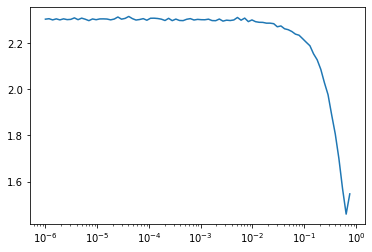

In [19]:
run.recorder.plot(skip_last=10)

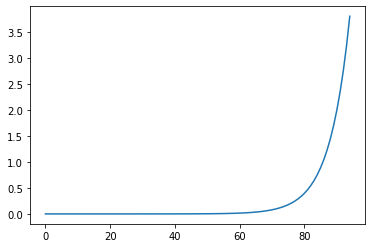

In [20]:
run.recorder.plot_lr()

In [21]:
!python notebook2script.py 06_runner2.ipynb

Converted 06_runner2.ipynb to exp\nb_06.py
